# Making masks

In [ ]:
%pip install "notebook<7"
%pip install ipympl opencv-python ipywidgets PyMaxflow

In [2]:
%matplotlib inline
%matplotlib widget
#try widget instead if graphs aren't showing

import os
import cv2
import maxflow
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import ipywidgets as widgets
from matplotlib.patches import Circle
from IPython.display import display

In [3]:
def graphcut(image, scribble_mask, lambda_val=50, sigma=10):
    H, W, _ = image.shape
    img = image.astype(np.float64)
    
    # identify scribbled regions
    fg_pixels = scribble_mask == 1  # definite foreground
    bg_pixels = scribble_mask == 2  # definite background
    
    # compute mean colors for scribbled foreground and background
    fg_mean = np.mean(img[fg_pixels], axis=0) if np.any(fg_pixels) else np.zeros(3)
    bg_mean = np.mean(img[bg_pixels], axis=0) if np.any(bg_pixels) else np.zeros(3)
    
    # data costs based on squared color distances
    data_cost_fg = np.sum((img - fg_mean)**2, axis=2)
    data_cost_bg = np.sum((img - bg_mean)**2, axis=2)
    
    # normalize the data costs
    data_cost_fg = data_cost_fg / (np.max(data_cost_fg) + 1e-8)
    data_cost_bg = data_cost_bg / (np.max(data_cost_bg) + 1e-8)
    
    # build the graph
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes((H, W))
    
    # terminal (data) capacities
    source_cap = data_cost_fg.copy()
    sink_cap = data_cost_bg.copy()
    
    # for scribbled pixels, force the label
    source_cap[scribble_mask == 1] = 0      # Force foreground.
    sink_cap[scribble_mask == 1] = 1e9
    source_cap[scribble_mask == 2] = 1e9      # Force background.
    sink_cap[scribble_mask == 2] = 0
    
    g.add_grid_tedges(nodeids, source_cap, sink_cap)
    
    # add smoothness (neighborhood) terms
    for i in range(H):
        for j in range(W):
            if j < W - 1:
                diff = np.linalg.norm(img[i, j] - img[i, j+1])
                weight = lambda_val * np.exp(- (diff**2) / (2 * sigma**2))
                g.add_edge(nodeids[i, j], nodeids[i, j+1], weight, weight)
                
            if i < H - 1:
                diff = np.linalg.norm(img[i, j] - img[i+1, j])
                weight = lambda_val * np.exp(- (diff**2) / (2 * sigma**2))
                g.add_edge(nodeids[i, j], nodeids[i+1, j], weight, weight)
                
    # compute the min-cut
    g.maxflow()
    seg_mask = np.zeros((H, W), dtype=bool)
    for i in range(H):
        for j in range(W):
            seg_mask[i, j] = True if g.get_segment(nodeids[i, j]) == 0 else False
            
    return seg_mask

ToggleButtons(description='Mode:', options=(('Foreground', 'foreground'), ('Background', 'background'), ('Eras…

IntSlider(value=10, description='Brush Size:', max=50, min=1)

Label(value='')

Output()

Loading: ../data/To_Remask_Images_Ash\PAT_100_393_595.png


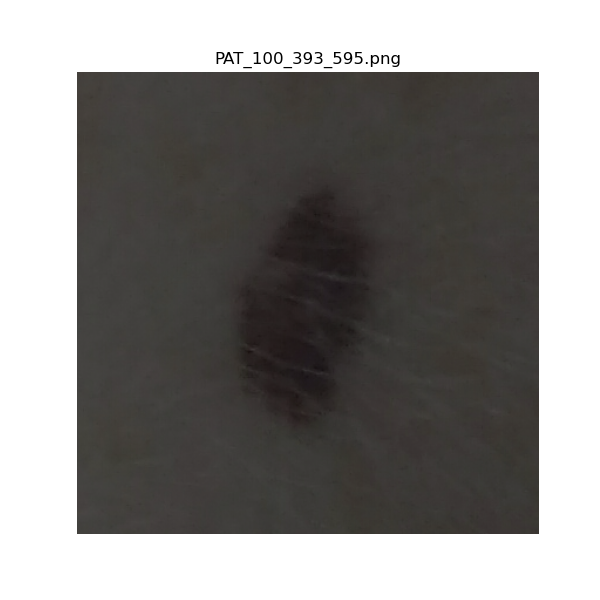

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Folder setup
image_folder = '../data/To_Remask_Images_Ash'
mask_output_folder = '../data/new_masks/masks'
cutout_output_folder = '../data/new_masks/cutouts'

os.makedirs(mask_output_folder, exist_ok=True)
os.makedirs(cutout_output_folder, exist_ok=True)

image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
current_index = 0
segmentation_done = False
seg_mask = None

# Globals
scribble_mask = None
overlay_data = None
scribble_points = []
dragging = False
current_mode = 'foreground'
fig = None
ax = None

# UI Elements
status_label = widgets.Label(value="")
brush_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Brush Size:',
    continuous_update=True
)

def check_if_done(index):
    filename_base = os.path.splitext(image_files[index])[0]
    mask_path = os.path.join(mask_output_folder, f"{filename_base}_mask.png")
    cutout_path = os.path.join(cutout_output_folder, f"{filename_base}_chopped.png")
    return os.path.exists(mask_path) and os.path.exists(cutout_path)

def load_image(index):
    global image, image_bgr, scribble_mask, overlay_data, overlay_image, scribble_points
    global fig, ax, dragging, segmentation_done

    image_path = os.path.join(image_folder, image_files[index])
    print(f"Loading: {image_path}")

    image_bgr = cv2.imread(image_path)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    scribble_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    overlay_data = np.zeros_like(image, dtype=np.uint8)
    scribble_points = []
    dragging = False
    segmentation_done = False

    already_segmented = check_if_done(index)
    status_label.value = "✅ Already segmented" if already_segmented else "❌ Not yet segmented"

    plt.close('all')
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)
    overlay_image = ax.imshow(overlay_data, alpha=0.5)
    ax.set_title(image_files[index])
    ax.axis('off')

    fig.canvas.mpl_connect('button_press_event', on_press)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)
    fig.canvas.mpl_connect('button_release_event', on_release)
    plt.show()

def draw_at(xdata, ydata):
    global scribble_mask, overlay_data, scribble_points
    if xdata is None or ydata is None:
        return
    x, y = int(xdata), int(ydata)
    radius = brush_slider.value

    if current_mode == 'eraser':
        radius *= 2
        cv2.circle(scribble_mask, (x, y), radius, 0, -1)
        cv2.circle(overlay_data, (x, y), radius, (0, 0, 0), -1)
        scribble_points = [pt for pt in scribble_points if (pt[0] - x)**2 + (pt[1] - y)**2 > radius**2]
        overlay_image.set_data(overlay_data)
        fig.canvas.draw_idle()
        return

    if current_mode == 'foreground':
        color = (255, 0, 0)
        mask_value = 1
    elif current_mode == 'background':
        color = (0, 0, 255)
        mask_value = 2
    else:
        return

    cv2.circle(scribble_mask, (x, y), radius, mask_value, -1)
    cv2.circle(overlay_data, (x, y), radius, color, -1)
    scribble_points.append((x, y, radius, color))
    overlay_image.set_data(overlay_data)
    fig.canvas.draw_idle()

def on_press(event):
    global dragging
    if event.inaxes != ax:
        return
    dragging = True
    draw_at(event.xdata, event.ydata)

def on_motion(event):
    if event.inaxes == ax and event.button is None:
        draw_at(event.xdata, event.ydata)


def on_release(event):
    global dragging
    dragging = False

def on_mode_change(change):
    global current_mode
    current_mode = change['new']

def on_segment_clicked(b):
    global seg_mask, segmentation_done
    with output:
        output.clear_output()
        print("Running Graph-Cut segmentation...")

    seg_mask = graphcut(image, scribble_mask)
    seg_mask = ~seg_mask

    segmentation_done = True

    filename_base = os.path.splitext(image_files[current_index])[0]
    mask_path = os.path.join(mask_output_folder, f"{filename_base}_mask.png")
    cutout = np.zeros_like(image)
    cutout[seg_mask] = image[seg_mask]
    cutout_path = os.path.join(cutout_output_folder, f"{filename_base}_chopped.png")

    cv2.imwrite(mask_path, (seg_mask.astype(np.uint8) * 255))
    cv2.imwrite(cutout_path, cv2.cvtColor(cutout, cv2.COLOR_RGB2BGR))

    print(f"Saved: {mask_path}")
    print(f"Saved: {cutout_path}")

    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.imshow(image)
    ax1.set_title("Original")
    ax1.axis('off')

    ax2.imshow(cutout)
    ax2.set_title(f"{filename_base}_chopped.png")
    ax2.axis('off')
    plt.show()

def on_next_image_clicked(b):
    global current_index, seg_mask, segmentation_done
    segmentation_done = False
    seg_mask = None
    current_index += 1
    if current_index < len(image_files):
        clear_output(wait=True)
        display_controls()
        load_image(current_index)
    else:
        print("All images processed.")

def on_prev_image_clicked(b):
    global current_index, seg_mask, segmentation_done
    if current_index > 0:
        segmentation_done = False
        seg_mask = None
        current_index -= 1
        clear_output(wait=True)
        display_controls()
        load_image(current_index)
    else:
        with output:
            output.clear_output()
            print("This is the first image.")

def on_undo_clicked(b):
    global scribble_points, scribble_mask, overlay_data
    if not scribble_points:
        return
    scribble_points.pop()
    scribble_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    overlay_data = np.zeros_like(image, dtype=np.uint8)
    for x, y, r, color in scribble_points:
        mask_value = 1 if color == (255, 0, 0) else 2
        cv2.circle(scribble_mask, (x, y), r, mask_value, -1)
        cv2.circle(overlay_data, (x, y), r, color, -1)
    overlay_image.set_data(overlay_data)
    fig.canvas.draw_idle()

def on_clear_clicked(b):
    global scribble_mask, overlay_data, scribble_points
    scribble_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    overlay_data = np.zeros_like(image, dtype=np.uint8)
    scribble_points = []
    overlay_image.set_data(overlay_data)
    fig.canvas.draw_idle()

# Widgets
mode_selector = widgets.ToggleButtons(
    options=[('Foreground', 'foreground'), ('Background', 'background'), ('Eraser', 'eraser')],
    description='Mode:'
)
mode_selector.observe(on_mode_change, names='value')

segmentation_button = widgets.Button(description="Run Graph-Cut")
segmentation_button.on_click(on_segment_clicked)

next_button = widgets.Button(description="→ Next Image")
next_button.on_click(on_next_image_clicked)

prev_button = widgets.Button(description="← Previous Image")
prev_button.on_click(on_prev_image_clicked)

undo_button = widgets.Button(description="↩ Undo")
undo_button.on_click(on_undo_clicked)

clear_button = widgets.Button(description="🧹 Clear All")
clear_button.on_click(on_clear_clicked)

output = widgets.Output()

def display_controls():
    buttons = widgets.HBox([prev_button, segmentation_button, next_button, undo_button, clear_button])
    display(mode_selector, brush_slider, buttons, status_label, output)

# Start
display_controls()
load_image(current_index)
